### Testing image embedding on video

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision, BaseOptions
from mediapipe.tasks.python.vision import ImageEmbedder, ImageEmbedderOptions, RunningMode

def display(img, cmap=None):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap)

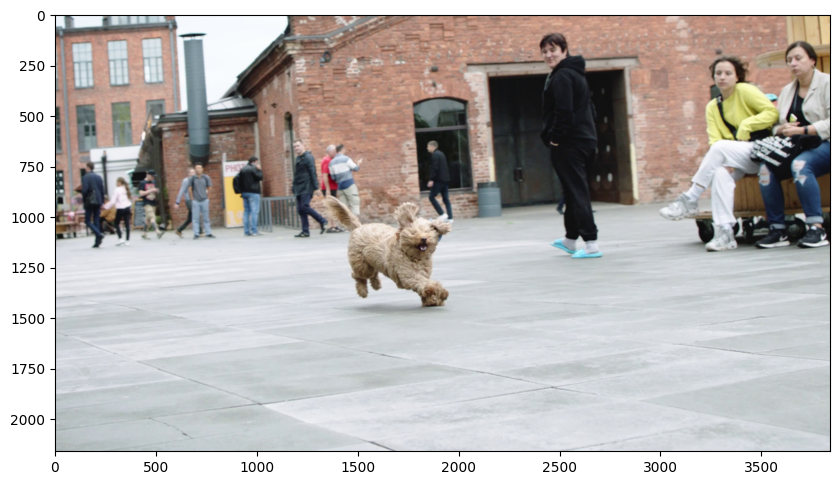

In [2]:
cap = cv2.VideoCapture("../videos/dog_1.mp4")
display(cv2.cvtColor(cap.read()[1], cv2.COLOR_BGR2RGB))

### How to load 2 videos and get their frames?

In [3]:
# VIDEO_FILENAMES = ["videos/dog_1.mp4", "videos/dog_2.mp4"]

# # Get number of frames for each video
# VIDEO_FRAMES = []

# for video in VIDEO_FILENAMES:
#     cap = cv2.VideoCapture(video)

#     FRAMES = []
#     for i in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
#         ret, frame = cap.read()
#         FRAMES.append(frame)

#     print(f"Frames found in {video}: {len(FRAMES)}")
#     VIDEO_FRAMES.append(FRAMES)
#     cap.release()

# # Handle missmatch in frames -> adjust number of frames
# MIN_FRAMES = min([len(frames) for frames in VIDEO_FRAMES])
# print(f"Adjusting frames for both videos. New number of frames: {MIN_FRAMES}")
# VIDEO_FRAMES = [frames[:MIN_FRAMES] for frames in VIDEO_FRAMES]

### Iterate over both videos and compare their frames

In [4]:
VIDEO_FILENAMES = ["../videos/dog_1.mp4", "../videos/dog_2.mp4"]

# Get number of frames for each video
VIDEO_FRAMES = []

for video in VIDEO_FILENAMES:
    cap = cv2.VideoCapture(video)

    FRAMES = []
    for i in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        FRAMES.append(frame)

    print(f"Frames found in {video}: {len(FRAMES)}")
    VIDEO_FRAMES.append(FRAMES)
    cap.release()

# Handle missmatch in frames -> adjust number of frames
MIN_FRAMES = min([len(frames) for frames in VIDEO_FRAMES])
print(f"Adjusting frames for both videos. New number of frames: {MIN_FRAMES}")
VIDEO_FRAMES = [frames[:MIN_FRAMES] for frames in VIDEO_FRAMES]

base_options = BaseOptions(model_asset_path="../mobilenet_v3_large_075_224_embedder.tflite")
options = ImageEmbedderOptions(
    base_options=base_options,
    l2_normalize=True,
    quantize=True)

TARGET_WIDTH = 700
TARGET_HEIGHT = 600
similarities = []
with ImageEmbedder.create_from_options(options) as embedder:
    for i in range(MIN_FRAMES):
        vid1_frame_mat = VIDEO_FRAMES[0][i]
        vid2_frame_mat = VIDEO_FRAMES[1][i]

        # Resize the frames to the target dimensions
        vid1_frame_resized = cv2.resize(vid1_frame_mat, (TARGET_WIDTH, TARGET_HEIGHT))
        vid2_frame_resized = cv2.resize(vid2_frame_mat, (TARGET_WIDTH, TARGET_HEIGHT))
        
        # get embeddings
        vid1_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=vid1_frame_mat)
        vid2_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=vid2_frame_mat)
        first_embedding_result = embedder.embed(vid1_frame)
        second_embedding_result = embedder.embed(vid2_frame)

        # calculate similarity between frames
        similarity = ImageEmbedder.cosine_similarity(
            first_embedding_result.embeddings[0],
            second_embedding_result.embeddings[0])
        
        similarities.append(similarity)
        print(f"Similarity between frames {i}: {similarity}")
        
        # TODO: Display the frames side by side using OpenCV
        side_by_side = cv2.hconcat([vid1_frame_resized, vid2_frame_resized])

        # Add similarity text to the frame
        frame_center = (TARGET_WIDTH // 2 + 200, TARGET_HEIGHT - 50)
        cv2.putText(
            side_by_side,
            f"Similarity: {similarity:.2f}",
            frame_center,
            cv2.FONT_HERSHEY_SIMPLEX,
            1.5,
            (255, 255, 255),
            2,
        )

        # Display the concatenated frames
        cv2.imshow("Frames", side_by_side)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cv2.destroyAllWindows()

Frames found in ../videos/dog_1.mp4: 269
Frames found in ../videos/dog_2.mp4: 415
Adjusting frames for both videos. New number of frames: 269
Similarity between frames 0: 0.07618892766933967
Similarity between frames 1: 0.07898406482500434
Similarity between frames 2: 0.11711008183025721
Similarity between frames 3: 0.11008207844914078
Similarity between frames 4: 0.10329051418674107
Similarity between frames 5: 0.13022929060113939
Similarity between frames 6: 0.10381040771423902
Similarity between frames 7: 0.08901979072976729
Similarity between frames 8: 0.0856581075803233
Similarity between frames 9: 0.1089963534836037
Similarity between frames 10: 0.12068727141066192
Similarity between frames 11: 0.10756402806309526
Similarity between frames 12: 0.10986555730849332
Similarity between frames 13: 0.14179420362727652
Similarity between frames 14: 0.11450529698560943
Similarity between frames 15: 0.12454782691532401
Similarity between frames 16: 0.11343942780627174
Similarity between f

### Plot the results

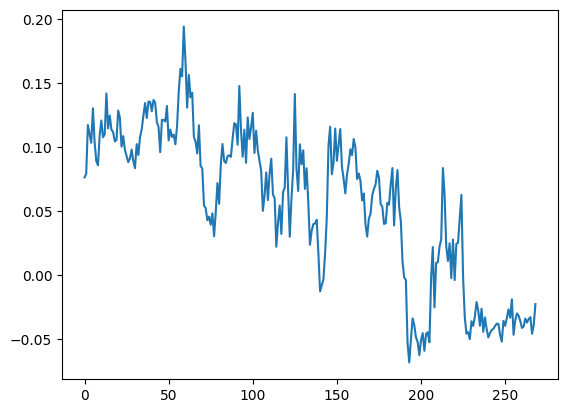

In [5]:
# MIN_FRAMES should be the X-axis
# similarities should be the Y-axis

plt.plot(range(MIN_FRAMES), similarities)